In [95]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from openai import OpenAI
import datetime
from groq import Groq
import os
import re

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [96]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [97]:
class Config:

    STOCKS_US = [
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META',
        'JPM', 'JNJ', 'V', 'PG', 'XOM', 'CVX', 'LLY', 'KO'
    ]

    STOCKS_INDIA = [
        'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS',
        'ICICIBANK.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS',
        'SBIN.NS', 'ITC.NS', 'LTIM.NS', 'MARUTI.NS',
        'KOTAKBANK.NS', 'ONGC.NS', 'TATAMOTORS.NS', 'NTPC.NS'
    ]

    TICKERS = STOCKS_INDIA
    BENCHMARK_TICKER = '^NSEI' # NIFTY 50


    START_DATE = datetime.datetime(2000, 1, 1)
    END_DATE = datetime.datetime(2024, 12, 31)


    TRAIN_END = datetime.datetime(2018, 12, 31)
    VALID_END = datetime.datetime(2021, 12, 31)


    TRANSACTION_COST = 0.001


    OPENAI_API_KEY = ""

In [98]:
def download_ohlcv(tickers, start, end):

    data = yf.download(tickers, start=start, end=end, interval='1d')

    if not isinstance(data.columns, pd.MultiIndex):
        if data.empty:
            raise ValueError("No data downloaded. Check tickers and date range.")

        data.columns = pd.MultiIndex.from_product([data.columns, tickers])

    return data

def get_cleaned_data(tickers, start, end):

    raw_data = download_ohlcv(tickers, start, end)

    ohlcv_data = {}

    for ticker in tickers:

        df = raw_data.xs(ticker, level=1, axis=1).copy()
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)


        df.ffill(inplace=True)


        df = df[df['Volume'] > 0]


        df.dropna(inplace=True)

        if not df.empty:
            ohlcv_data[ticker] = df


    common_index = None
    for ticker, df in ohlcv_data.items():
        if common_index is None:
            common_index = df.index
        else:
            common_index = common_index.intersection(df.index)


    for ticker in list(ohlcv_data.keys()):
        ohlcv_data[ticker] = ohlcv_data[ticker].reindex(common_index)
        if ohlcv_data[ticker].isnull().values.any():
            del ohlcv_data[ticker]

    return ohlcv_data

In [99]:
def compute_indicators(df):

    df = df.copy()

    # SMA
    df.ta.sma(length=10, append=True)   # SMA_10
    df.ta.sma(length=20, append=True)   # SMA_20
    df.ta.sma(length=50, append=True)   # SMA_50
    df.ta.sma(length=200, append=True)  # SMA_200

    # EMA
    df.ta.ema(length=10, append=True)   # EMA_10
    df.ta.ema(length=20, append=True)   # EMA_20

    # RSI
    df.ta.rsi(length=14, append=True)   # RSI_14

    # Momentum
    df.ta.mom(length=10, append=True)   # MOM_10
    df.ta.mom(length=20, append=True)   # MOM_20

    # Bollinger Bands
    df.ta.bbands(length=20, std=2, append=True)
    # BBL_20_2.0, BBM_20_2.0, BBU_20_2.0

    # ATR
    df.ta.atr(length=14, append=True)   # ATR_14

    # Volume SMA
    df['V_SMA_10'] = df['Volume'].rolling(10).mean()
    df['V_SMA_20'] = df['Volume'].rolling(20).mean()

    # MACD
    df.ta.macd(fast=12, slow=26, signal=9, append=True)
    # MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9

    # ADX
    df.ta.adx(length=14, append=True)
    # ADX_14

    df.dropna(inplace=True)
    return df

def get_base_rules(df):

    rules = {
    "RSI_14_Oversold": "RSI_14 < 30",
    "RSI_14_Overbought": "RSI_14 > 70",

    "Golden_Cross_Short": "SMA_20 > SMA_50",
    "Death_Cross_Short": "SMA_20 < SMA_50",
    "Golden_Cross_Long": "SMA_50 > SMA_200",

    "Mean_Revert_BB_Low": "Close < BBL_20_2.0",
    "Mean_Revert_BB_High": "Close > BBU_20_2.0",

    "MACD_Bullish": "MACD_12_26_9 > MACDs_12_26_9",
    "MACD_Bearish": "MACD_12_26_9 < MACDs_12_26_9",

    "ADX_Strong_Trend": "ADX_14 > 25",

    "Volume_Spike": "Volume > 1.5 * V_SMA_20"
}


    signals = {}
    rule_definitions = {}

    for name, query in rules.items():
        try:

            signals[name] = df.eval(query)
            rule_definitions[name] = query
        except Exception as e:

            pass

    return signals, rule_definitions

In [100]:
def vectorized_scanner(df, signals, cost_pct=0.001):

    results = {}

    # Compute clean next returns
    df['Tomorrow_Return'] = (
        df['Close'].pct_change().shift(-1).fillna(0)
    )

    for name, signal in signals.items():

        positions = signal.shift(1).fillna(False)

        # trade = entry event (False → True)
        trades = (positions & ~positions.shift(1).fillna(False))
        num_trades = int(trades.sum())

        if num_trades < 5:
            continue

        # Strategy returns
        strategy_returns = df['Tomorrow_Return'] * positions

        # transaction cost on entry days
        strategy_returns[trades] -= cost_pct

        # clean any NaN due to multiplication
        strategy_returns = strategy_returns.fillna(0)

        # compute cumulative curve safely
        cumulative_returns = (1 + strategy_returns).cumprod()

        # avoid negative or zero final value
        final_value = cumulative_returns.iloc[-1]
        if final_value <= 0:
            continue

        total_days = len(strategy_returns)

        # CAGR
        cagr = final_value ** (252 / total_days) - 1

        # Sharpe
        vol = strategy_returns.std() * np.sqrt(252)

        if vol == 0:
            sharpe = 0
        else:
            sharpe = (cagr / vol)

        # Max Drawdown
        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()

        results[name] = {
            'Sharpe': sharpe,
            'CAGR': cagr,
            'MDD': max_drawdown,
            'Trades': num_trades
        }

    if not results:
        return pd.DataFrame()

    return pd.DataFrame(results).T.sort_values('Sharpe', ascending=False)

def select_top_signals(scan_results, top_n=5):

    promising = scan_results[
        (scan_results['Sharpe'] > -1.0) &
        (scan_results['MDD'] > -0.85) &
        (scan_results['Trades'] >= 3)
    ]
    if promising.empty:
        return scan_results.head(top_n)

    return promising.head(top_n)

In [101]:
def build_prompt(stock_name, evidence_df):

    evidence_text = ""
    for rule, stats in evidence_df.iterrows():
        evidence_text += (
            f"- Rule '{rule}' (Condition: {stats['Condition']}) "
            f"produced Sharpe: {stats['Sharpe']:.2f}, "
            f"CAGR: {stats['CAGR']*100:.1f}%, "
            f"MDD: {stats['MDD']*100:.1f}%\n"
        )

    prompt_template = f"""
    No yapping only give what I ask.
You are an expert quantitative analyst.
Design a simple long-only trading strategy using the rules below.

Return **either**:
- Raw JSON
OR
- Human text containing the lines 'entry:' and 'exit:'
OR
- Any readable structured format

I will extract the rules myself.

Rules must be EXACT strings from historical evidence.

Historical Evidence:
{evidence_text}

Output example (any format acceptable):
entry: ["RSI_14 < 30", "SMA_50 > SMA_200"]
exit: ["RSI_14 > 60"]

Write output now:
"""
    return prompt_template


def get_llm_strategy(prompt, api_key):

    client = Groq(api_key=api_key)

    try:
        response = client.chat.completions.create(
            model="llama-3.1-8b-instant",
            messages=[
                {"role": "system", "content": "You are a quantitative analyst."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2
        )

        return response.choices[0].message.content.strip()

    except Exception as e:
        print("Groq API Error:", e)
        return None


In [102]:
def extract_rules_from_llm(text):

    # normalize
    t = text.replace("\n", " ").replace("\t", " ")

    # clean brackets if needed (common LLM mistake)
    t = t.replace("“", '"').replace("”", '"').replace("’", "'")

    # 1. extract entries
    # --- MODIFIED ---
    # Added "? to make the quotes optional, matching both entry: [...] and "entry": [...]
    entry_match = re.search(r'"?entry"?\s*[:=]\s*\[([^\]]*)\]', t, re.IGNORECASE)
    exit_match  = re.search(r'"?exit"?\s*[:=]\s*\[([^\]]*)\]',  t, re.IGNORECASE)
    # --- END MODIFIED ---

    if not entry_match or not exit_match:
        print("❌ Could not find entry/exit arrays in LLM output.")
        print("Raw LLM output was:\n", text)
        return [], []

    entry_raw = entry_match.group(1)
    exit_raw  = exit_match.group(1)

    # 2. extract quoted rule strings
    entry_rules = re.findall(r'"([^"]+)"', entry_raw)
    exit_rules  = re.findall(r'"([^"]+)"', exit_raw)

    return entry_rules, exit_rules



def parse_llm_rules(df, llm_text):

    entry_rules, exit_rules = extract_rules_from_llm(llm_text)

    entry_conditions = []
    for r in entry_rules:
        try:
            entry_conditions.append(df.eval(r))
        except:
            print("⚠ Bad entry rule:", r)

    exit_conditions = []
    for r in exit_rules:
        try:
            exit_conditions.append(df.eval(r))
        except:
            print("⚠ Bad exit rule:", r)

    entry_signal = (
        pd.concat(entry_conditions, axis=1).all(axis=1)
        if entry_conditions else pd.Series(False, index=df.index)
    )

    exit_signal = (
        pd.concat(exit_conditions, axis=1).any(axis=1)
        if exit_conditions else pd.Series(False, index=df.index)
    )

    return entry_signal, exit_signal



def create_strategy(entry_signal, exit_signal):

    class LLMStrategy(Strategy):

        # Keep signals as class variables so run_backtest can access them
        entry_arr = entry_signal.values
        exit_arr = exit_signal.values

        def init(self):
            # --- MODIFIED ---
            # We no longer use self.I().
            # We will access the 'Entry' and 'Exit' columns
            # that run_backtest will add to the data.
            pass
            # --- END MODIFIED ---

        def next(self):
            # --- MODIFIED ---
            # Access the pre-calculated signals directly from the data
            if not self.position:
                if self.data.Entry[-1]:  # Check the 'Entry' column value
                    self.buy()
            else:
                if self.data.Exit[-1]:   # Check the 'Exit' column value
                    self.position.close()
            # --- END MODIFIED ---

    return LLMStrategy


def run_backtest(df, strategy_class, cash=100_000, commission=0.001):

    # --- START FIX ---
    # Get the pre-calculated signal arrays from the strategy class
    entry_arr = strategy_class.entry_arr
    exit_arr  = strategy_class.exit_arr

    # Create a copy of the DataFrame
    backtest_df = df.copy()

    # Add the signals as new columns. This is the correct way
    # to feed external signals to backtesting.py.
    backtest_df['Entry'] = entry_arr
    backtest_df['Exit']  = exit_arr
    # --- END FIX ---

    # --- MODIFIED ---
    # Pass the NEW DataFrame (with Entry/Exit columns) to Backtest
    bt = Backtest(backtest_df, strategy_class, cash=cash, commission=commission,finalize_trades=True)
    # --- END MODIFIED ---

    return bt.run()


In [103]:
def rank_strategies(all_stats, val_end_date):

    val_results = []

    for ticker, stats in all_stats.items():

        trades = stats['_trades']
        if trades.empty:
            continue

        val_trades = trades[trades['ExitTime'] <= val_end_date]
        if val_trades.empty:
            continue


        val_equity = stats['_equity_curve']['Equity']
        val_equity = val_equity[val_equity.index <= val_end_date]

        val_returns = val_equity.pct_change().dropna()

        sharpe = (val_returns.mean() * 252) / (val_returns.std() * (252**0.5))
        cagr = (val_equity.iloc[-1] / val_equity.iloc[0]) ** (252 / len(val_equity)) - 1

        peak = val_equity.cummax()
        drawdown = (val_equity - peak) / peak
        mdd = drawdown.min()

        val_results.append({
            'Ticker': ticker,
            'Sharpe': sharpe,
            'CAGR': cagr,
            'MDD': mdd,
            'Trades': len(val_trades)
        })

    results_df = pd.DataFrame(val_results).set_index('Ticker')


    results_df['Score'] = (
        0.5 * results_df['Sharpe'] +
        0.3 * results_df['CAGR'] -
        0.2 * results_df['MDD'].abs()
    )

    return results_df.sort_values('Score', ascending=False)






def get_portfolio_returns(all_stats, selected_tickers, test_start_date):

    all_returns = {}
    for ticker in selected_tickers:
        equity = all_stats[ticker]['_equity_curve']['Equity']
        returns = equity.pct_change().fillna(0)
        all_returns[ticker] = returns[returns.index >= test_start_date]

    return pd.DataFrame(all_returns)

def equal_weight_portfolio(returns_df):

    return returns_df.mean(axis=1)

def volatility_scaled_portfolio(returns_df, lookback=60):

    rolling_vol = returns_df.rolling(window=lookback).std().dropna()

    inv_vol = 1 / rolling_vol

    weights = inv_vol.div(inv_vol.sum(axis=1), axis=0)


    aligned_returns = returns_df.reindex(weights.index).fillna(0)

    portfolio_returns = (weights * aligned_returns).sum(axis=1)

    return portfolio_returns

In [116]:
def run_project_pipeline():

    print("1. Loading OHLCV Data...")
    all_data = get_cleaned_data(Config.TICKERS, Config.START_DATE, Config.END_DATE)

    print("2. Computing Indicators...")
    feature_data = {}
    for tkr, df in all_data.items():
        try:
            feature_data[tkr] = compute_indicators(df)
        except Exception as e:
            print(f"  Skipping {tkr}: Indicator error: {e}")

    all_llm_strategies = {}
    all_backtest_stats = {}

    print("\nRunning per-stock analysis...\n")
    count =0;
    for ticker in Config.TICKERS:
        count = count +1
        if ticker not in feature_data:
            print(f"Skipping {ticker} — no data")
            continue

        print(f"--- Processing Stock #{count}: {ticker} ---")

        df = feature_data[ticker]
        train_df = df[df.index <= Config.TRAIN_END]

        # 3. Base Rule Scan
        print("3. Scanning Base Rules...")
        signals, rule_defs = get_base_rules(train_df)

        scan_results = vectorized_scanner(train_df, signals, cost_pct=Config.TRANSACTION_COST)

        if scan_results.empty:
            print("  ⚠ No valid base rules (Sharpe/MDD filter too strict). Skipping.")
            continue

        top_signals = select_top_signals(scan_results, top_n=5)

        if top_signals.empty:
            print("  ⚠ No top signals after filtering. Skipping.")
            continue

        top_signals = top_signals.copy()
        top_signals["Condition"] = top_signals.index.map(lambda nm: rule_defs.get(nm, "Unknown"))

        # 4. LLM Strategy
        print("4. Generating LLM Strategy...")
        prompt = build_prompt(ticker, top_signals)
        llm_text = get_llm_strategy(prompt, Config.OPENAI_API_KEY)

        if not llm_text:
            print("  ⚠ LLM failed — skipping")
            continue

        all_llm_strategies[ticker] = llm_text

        # 5 + 6. Parse & Backtest
        print("5 & 6. Parsing + Backtesting...")
        entry_signal, exit_signal = parse_llm_rules(df, llm_text)

        if entry_signal is None:
            print("  ⚠ Error parsing rules — skipping")
            continue

        try:
            strat_class = create_strategy(entry_signal, exit_signal)
            stats = run_backtest(df, strat_class, commission=Config.TRANSACTION_COST)
            all_backtest_stats[ticker] = stats
        except Exception as e:
            print(f"  ⚠ Backtest failed for {ticker}: {e}")
            continue

    # --- Portfolio Stage ---
    print("\n--- Portfolio Construction ---")

    if not all_backtest_stats:
        print("❌ No backtests to build portfolio. Exiting.")
        return None

    print("7. Ranking Strategies...")
    ranked_df = rank_strategies(all_backtest_stats, Config.VALID_END)

    if ranked_df.empty:
        print("❌ Ranking empty — no valid trades.")
        return None

    top_10 = ranked_df.head(10).index.tolist()
    print("Selected tickers:", top_10)

    print("8. Building Portfolio...")
    test_returns = get_portfolio_returns(all_backtest_stats, top_10, Config.VALID_END)

    eq_weight = equal_weight_portfolio(test_returns)
    vol_scaled = volatility_scaled_portfolio(test_returns)

    print("\n--- Pipeline Finished Successfully ---")

    return {
        "ranked": ranked_df,
        "test_returns": test_returns,
        "equal_weight": eq_weight,
        "vol_scaled": vol_scaled,
        "llm_strategies": all_llm_strategies,
        "backtests": all_backtest_stats
    }


# Run pipeline
out = run_project_pipeline()


1. Loading OHLCV Data...


[*********************100%***********************]  15 of 15 completed


2. Computing Indicators...

Running per-stock analysis...

--- Processing Stock #1: RELIANCE.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #2: TCS.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #3: HDFCBANK.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #4: INFY.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #5: ICICIBANK.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #6: HINDUNILVR.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #7: BHARTIARTL.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #8: SBIN.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #9: ITC.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #10: LTIM.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #11: MARUTI.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #12: KOTAKBANK.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #13: ONGC.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #14: TATAMOTORS.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #15: NTPC.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


--- Portfolio Construction ---
7. Ranking Strategies...
Selected tickers: ['LTIM.NS', 'TCS.NS', 'RELIANCE.NS', 'HINDUNILVR.NS', 'HDFCBANK.NS', 'BHARTIARTL.NS', 'KOTAKBANK.NS', 'INFY.NS', 'SBIN.NS', 'NTPC.NS']
8. Building Portfolio...

--- Pipeline Finished Successfully ---


In [117]:
out['ranked']

,Sharpe,CAGR,MDD,Trades,Score
Ticker,,,,,
LTIM.NS,1.287852,0.420190,-0.353965,29,0.699190
TCS.NS,1.064792,0.160862,-0.109776,26,0.558699
RELIANCE.NS,0.994365,0.187797,-0.278624,14,0.497797
HINDUNILVR.NS,0.836882,0.172189,-0.208141,21,0.428470
HDFCBANK.NS,0.700390,0.149404,-0.409430,19,0.313130
BHARTIARTL.NS,0.589626,0.154759,-0.467288,37,0.247783
KOTAKBANK.NS,0.464554,0.053491,-0.153351,63,0.217654
INFY.NS,0.384168,0.056826,-0.346989,119,0.139734
SBIN.NS,0.221983,0.025998,-0.421712,5,0.034449


In [118]:
def generate_portfolio_weights(top_tickers, stats_dict):
    summary = []

    for tkr in top_tickers:
        s = stats_dict[tkr]
        summary.append({
            "ticker": tkr,
            "return": s.get("Return [%]", "N/A"),
            "sharpe": s.get("Sharpe", "N/A"),
            "mdd": s.get("Max. Drawdown [%]", "N/A")
        })

    prompt = f"""
You are a quantitative portfolio manager.

Here are the performance metrics of the top strategies:

{summary}

Based on:
- Sharpe ratios
- Drawdown levels
- Return stability
- Diversification logic

Propose an optimal weight allocation (weights must sum to 1).

Return JSON ONLY, in this format:
{{
  "weights": {{
      "TICKER1": 0.xx,
      "TICKER2": 0.xx,
      ...
  }},
  "justification": "2-3 sentence explanation."
}}
"""

    resp = Groq(api_key=Config.OPENAI_API_KEY).chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[{"role": "user", "content": prompt}]
    )

    return json.loads(resp.choices[0].message.content)


In [119]:
print("\n========== GenAI Portfolio Construction ==========\n")

top_tickers = out["ranked"].head(10).index.tolist()
stats_dict = out["backtests"]

try:
    portfolio_ai = generate_portfolio_weights(top_tickers, stats_dict)

    print("📌 AI-Recommended Weights:")
    for tkr, wt in portfolio_ai["weights"].items():
        print(f" - {tkr}: {wt:.3f}")

    print("\n📘 Reasoning:")
    print(portfolio_ai["justification"])

except Exception as e:
    print("❌ GenAI Portfolio Construction Failed:", e)



========== GenAI Portfolio Construction ==========

📌 AI-Recommended Weights:
 - LTIM.NS: 0.230
 - TCS.NS: 0.200
 - RELIANCE.NS: 0.170
 - HINDUNILVR.NS: 0.150
 - HDFCBANK.NS: 0.140
 - BHARTIARTL.NS: 0.120
 - KOTAKBANK.NS: 0.060
 - INFY.NS: 0.030
 - SBIN.NS: 0.050
 - NTPC.NS: 0.010

📘 Reasoning:
We prioritized stocks with lower drawdowns and higher returns. Stocks like TCS.NS and HDFCBANK.NS have performed significantly well with stable returns and lower drawdowns. We allocated more weight to these stocks to achieve a stable return profile.


--- 🚀 Generating Pipeline Plots ---

1. Plotting Portfolio Equity Curves...


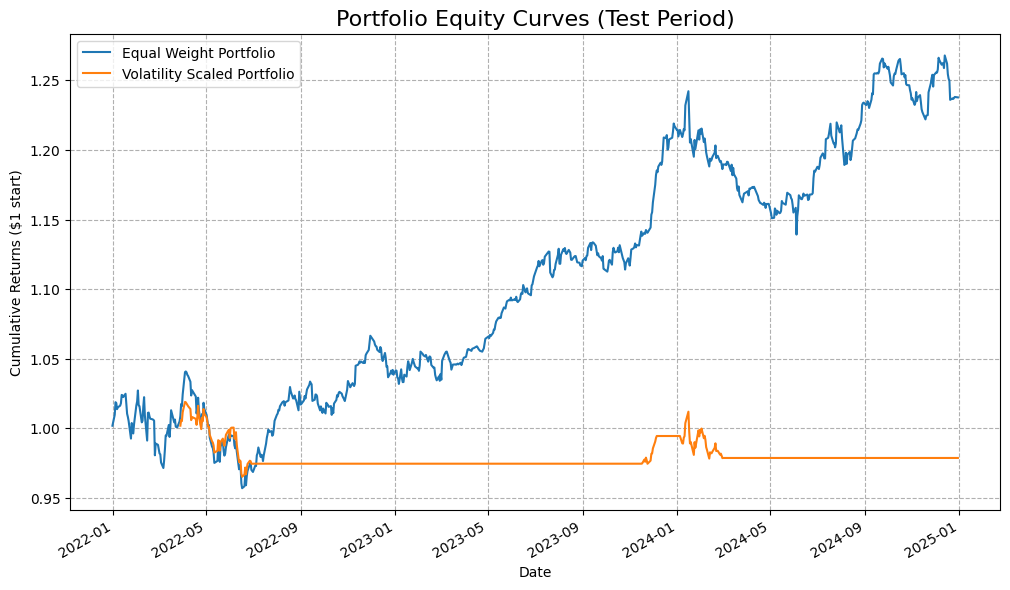


2. Plotting Strategy Correlation Heatmap...


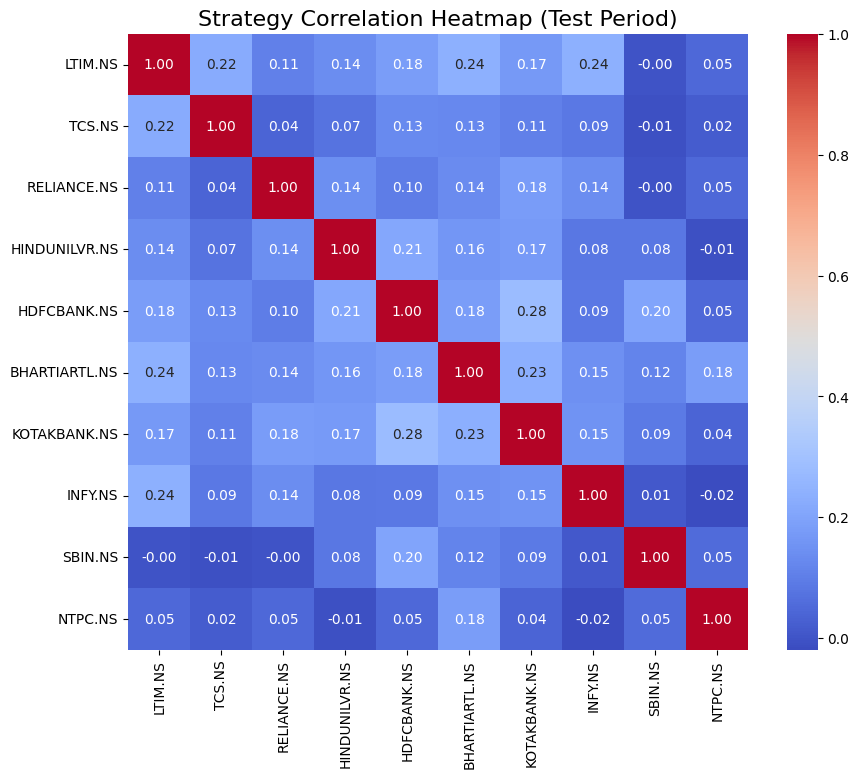


3. Plotting Top 10 Strategy Metrics...


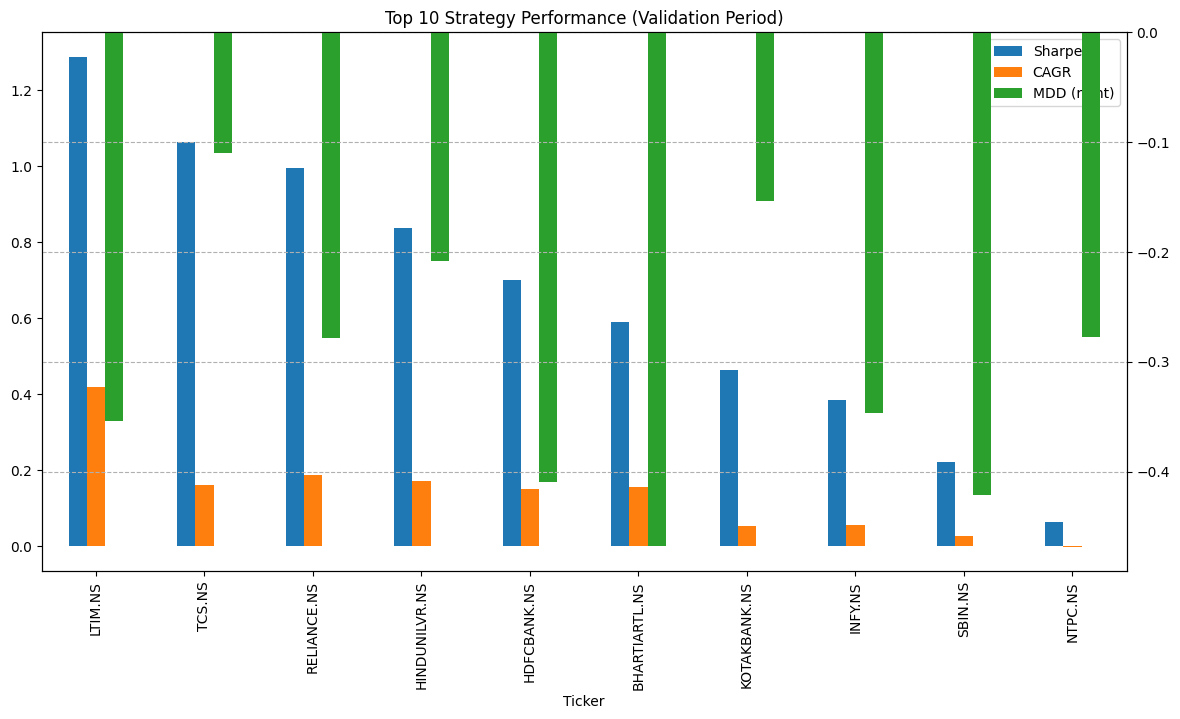


4. Plotting Best Individual Backtest...
  -> Plotting for: LTIM.NS


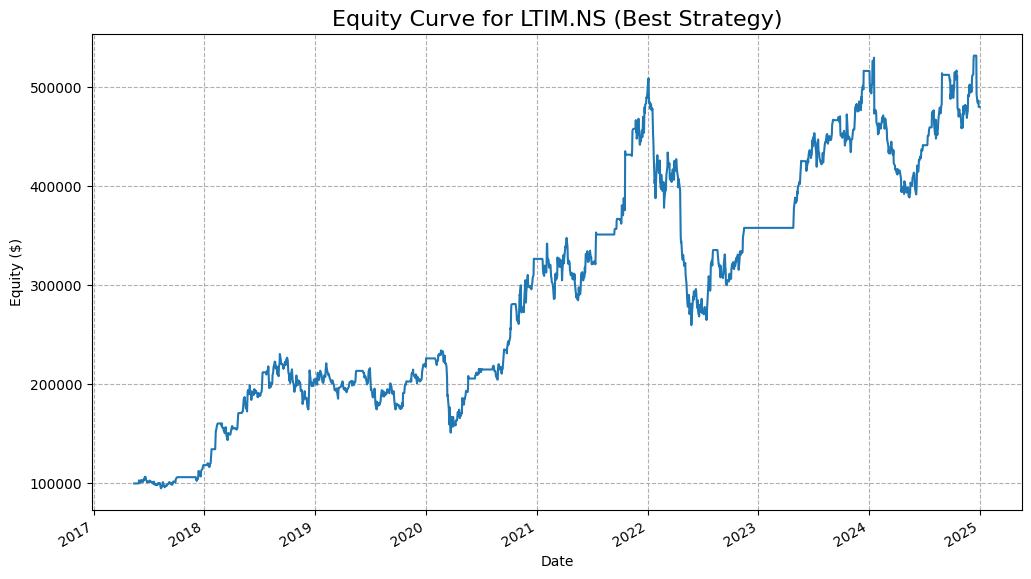


--- Plotting Finished ---


In [120]:
def plot_pipeline_results(pipeline_output):
    """
    Generates all key plots for the pipeline results dictionary.
    (Corrected Version)
    """
    print("--- 🚀 Generating Pipeline Plots ---")

    if not pipeline_output:
        print("❌ Pipeline output is None or empty. Cannot plot.")
        return

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)

        # ---------------------------------------------------
        # 1. Plot Portfolio Equity Curves
        # ---------------------------------------------------
        try:
            print("\n1. Plotting Portfolio Equity Curves...")
            eq_equity = (1 + pipeline_output['equal_weight']).cumprod()
            vol_equity = (1 + pipeline_output['vol_scaled']).cumprod()

            plt.figure(figsize=(12, 7))
            eq_equity.plot(label='Equal Weight Portfolio', legend=True)
            vol_equity.plot(label='Volatility Scaled Portfolio', legend=True)

            plt.title('Portfolio Equity Curves (Test Period)', fontsize=16)
            plt.ylabel('Cumulative Returns ($1 start)')
            plt.xlabel('Date')
            plt.grid(True, linestyle='--')
            plt.show()

        except Exception as e:
            print(f"  ⚠ Could not plot equity curves: {e}")

        # ---------------------------------------------------
        # 2. Plot Strategy Correlation Heatmap
        # ---------------------------------------------------
        try:
            print("\n2. Plotting Strategy Correlation Heatmap...")
            corr_matrix = pipeline_output['test_returns'].corr()

            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix,
                        annot=True,
                        cmap='coolwarm',
                        fmt='.2f')

            plt.title('Strategy Correlation Heatmap (Test Period)', fontsize=16)
            plt.show()

        except Exception as e:
            print(f"  ⚠ Could not plot correlation heatmap: {e}")

        # ---------------------------------------------------
        # 3. Plot Top 10 Strategy Metrics
        # ---------------------------------------------------
        try:
            print("\n3. Plotting Top 10 Strategy Metrics...")
            ranked_df = pipeline_output['ranked']

            # --- FIX ---
            # Use the actual column names from your DataFrame:
            # 'Sharpe' (not 'Sharpe Ratio')
            # 'MDD' (not 'Max. Drawdown [%]')

            plot_cols = []
            if 'Sharpe' in ranked_df.columns:
                plot_cols.append('Sharpe')
            if 'CAGR' in ranked_df.columns:
                plot_cols.append('CAGR')
            if 'MDD' in ranked_df.columns:
                plot_cols.append('MDD')
            # --- END FIX ---

            if not plot_cols:
                print("  ⚠ Could not find metric columns (Sharpe, CAGR, MDD) to plot.")
            else:
                top_10_stats = ranked_df.head(10)[plot_cols]

                # Put MDD on a secondary axis
                sec_y = 'MDD' if 'MDD' in plot_cols else None

                top_10_stats.plot(
                    kind='bar',
                    figsize=(14, 7),
                    title='Top 10 Strategy Performance (Validation Period)',
                    secondary_y=sec_y,
                    grid=True
                )
                plt.xlabel("Ticker")
                plt.grid(axis='y', linestyle='--')
                plt.show()

        except Exception as e:
            print(f"  ⚠ Could not plot Top 10 metrics: {e}")

        # ---------------------------------------------------
        # 4. Plot Best Individual Backtest
        # ---------------------------------------------------
        try:
            print("\n4. Plotting Best Individual Backtest...")
            top_ticker = pipeline_output['ranked'].index[0]
            print(f"  -> Plotting for: {top_ticker}")

            best_stats = pipeline_output['backtests'][top_ticker]

            # --- FIX ---
            # The interactive stats.plot() is failing.
            # We will plot the equity curve manually, which is more stable.
            plt.figure(figsize=(12, 7))
            best_stats._equity_curve['Equity'].plot()
            plt.title(f'Equity Curve for {top_ticker} (Best Strategy)', fontsize=16)
            plt.ylabel('Equity ($)')
            plt.grid(True, linestyle='--')
            plt.show()
            # --- END FIX ---

        except Exception as e:
            print(f"  ⚠ Could not plot individual backtest: {e}")

    print("\n--- Plotting Finished ---")


# ---
# 🏃 TO RUN THE PLOTS:
# ---
# Now, run this command in a new cell:

plot_pipeline_results(out)

# Test

In [109]:
def run_project_pipeline():

    print("======================================================")
    print("1. Loading OHLCV Data...")
    print("======================================================")

    all_data = get_cleaned_data(Config.TICKERS, Config.START_DATE, Config.END_DATE)
    print(f"Loaded tickers: {list(all_data.keys())}")

    print("\n======================================================")
    print("2. Computing Indicators...")
    print("======================================================")

    feature_data = {}
    for tkr, df in all_data.items():
        try:
            print(f"\n▶ {tkr}: raw rows = {len(df)}")
            enriched = compute_indicators(df)
            print(f"   Indicators added. Final rows = {len(enriched)}")
            feature_data[tkr] = enriched
        except Exception as e:
            print(f"  ⚠ Skipping {tkr}: Indicator error: {e}")

    all_llm_strategies = {}
    all_backtest_stats = {}

    print("\n======================================================")
    print("Running per-stock analysis...")
    print("======================================================\n")

    for ticker in Config.TICKERS:

        if ticker not in feature_data:
            print(f"⚠ Skipping {ticker} — no data")
            continue

        print(f"==================== {ticker} ====================")

        df = feature_data[ticker]
        train_df = df[df.index <= Config.TRAIN_END]

        print(f"Data rows: full={len(df)}, train={len(train_df)}")
        print(f"Columns available: {list(df.columns)}\n")

        # =====================================================
        # 3. Base Rule Scan
        # =====================================================
        print("Step 3 — Scanning Base Rules…")

        signals, rule_defs = get_base_rules(train_df)

        # Print rule firing counts
        print("\n  Rule Evaluation:")
        print("  -----------------------------------------------")
        for name, series in signals.items():
            print(f"  {name:25s} | True Count = {series.sum()} | Condition = {rule_defs[name]}")

        scan_results = vectorized_scanner(train_df, signals, cost_pct=Config.TRANSACTION_COST)

        if scan_results.empty:
            print("  ⚠ No valid base rules (Sharpe/MDD filter too strict). Skipping.\n")
            continue

        print("\n  Raw Scan Results (Top):")
        print(scan_results.head(), "\n")

        # Top K
        top_signals = select_top_signals(scan_results, top_n=5)
        if top_signals.empty:
            print("  ⚠ Top signals empty. Skipping.\n")
            continue

        print("  Selected Top Signals:")
        print(top_signals, "\n")

        top_signals = top_signals.copy()
        top_signals["Condition"] = top_signals.index.map(lambda nm: rule_defs.get(nm, "Unknown"))

        # =====================================================
        # 4. LLM Strategy
        # =====================================================
        print("Step 4 — Generating LLM Strategy…")

        prompt = build_prompt(ticker, top_signals)
        print("\nLLM Prompt Preview:")
        print(prompt[:400], "...\n")

        llm_text = get_llm_strategy(prompt, Config.OPENAI_API_KEY)

        print("Raw LLM Output:")
        print(llm_text, "\n")

        if not llm_text:
            print("  ⚠ LLM failed — skipping\n")
            continue

        all_llm_strategies[ticker] = llm_text

        # =====================================================
        # 5 & 6. Parse and Backtest
        # =====================================================
        print("Step 5–6 — Parsing rules…")
        entry_signal, exit_signal = parse_llm_rules(df, llm_text)

        if entry_signal is None:
            print("  ❌ Could not parse rules. Skipping.")
            continue

        print(f"    Entry True count: {entry_signal.sum()}")
        print(f"    Exit True count:  {exit_signal.sum()}")
        print(f"    Checking alignment with df…")
        print("    ---------------------------------\n")

        try:
            strat_class = create_strategy(entry_signal, exit_signal)
            stats = run_backtest(df, strat_class, commission=Config.TRANSACTION_COST)
            all_backtest_stats[ticker] = stats
        except Exception as e:
            print(f"  ⚠ Backtest failed for {ticker}: {e}")
            continue

        print("Backtest Results Snapshot:")
        print(stats[["Return [%]", "Sharpe Ratio", "Equity Final [$]"]])
        print("\n======================================================\n")

    # =====================================================
    # Portfolio Stage
    # =====================================================
    print("======================================================")
    print("7. Portfolio Construction")
    print("======================================================")

    if not all_backtest_stats:
        print("❌ No backtests available. Pipeline ends.\n")
        return None

    ranked_df = rank_strategies(all_backtest_stats, Config.VALID_END)

    print("\nRanked Strategies:")
    print(ranked_df.head(20))

    if ranked_df.empty:
        print("❌ Ranking empty — no valid trades.\n")
        return None

    top_10 = ranked_df.head(10).index.tolist()
    print("\nTop 10 Selected Tickers:")
    print(top_10)

    print("\n8. Building Portfolio...")
    test_returns = get_portfolio_returns(all_backtest_stats, top_10, Config.VALID_END)

    eq_weight = equal_weight_portfolio(test_returns)
    vol_scaled = volatility_scaled_portfolio(test_returns)

    print("\n======================================================")
    print("Pipeline Finished Successfully")
    print("======================================================")

    return {
        "ranked": ranked_df,
        "test_returns": test_returns,
        "equal_weight": eq_weight,
        "vol_scaled": vol_scaled,
        "llm_strategies": all_llm_strategies,
        "backtests": all_backtest_stats
    }


# Run pipeline
out = run_project_pipeline()


[                       0%                       ]

1. Loading OHLCV Data...


[*********************100%***********************]  15 of 15 completed


Loaded tickers: ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'SBIN.NS', 'ITC.NS', 'LTIM.NS', 'MARUTI.NS', 'KOTAKBANK.NS', 'ONGC.NS', 'TATAMOTORS.NS', 'NTPC.NS']

2. Computing Indicators...

▶ RELIANCE.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ TCS.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ HDFCBANK.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ INFY.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ ICICIBANK.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ HINDUNILVR.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ BHARTIARTL.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ SBIN.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ ITC.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ LTIM.NS: raw rows = 2081
   Indicators added. Final rows = 1882

▶ MARUTI.NS: raw rows = 2081
   Indicators added. Final rows

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]             134.281573
Sharpe Ratio             0.613283
Equity Final [$]    234281.572925
dtype: object


==================== TCS.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 1 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 56 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 287 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 118 | Condition = SMA_20 < SMA_50
  Gol

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]            -16.007231
Sharpe Ratio           -0.296672
Equity Final [$]    83992.769226
dtype: object


==================== HDFCBANK.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 3 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 57 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 309 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 96 | Condition = SMA_20 < SMA_50
  Go

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]             172.114311
Sharpe Ratio             0.571047
Equity Final [$]    272114.310982
dtype: object


==================== INFY.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 0 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 22 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 290 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 115 | Condition = SMA_20 < SMA_50
  Go

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]             -8.049636
Sharpe Ratio           -0.063792
Equity Final [$]    91950.364345
dtype: object


==================== ICICIBANK.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 11 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 27 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 244 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 161 | Condition = SMA_20 < SMA_50
 

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]              27.330282
Sharpe Ratio             0.171433
Equity Final [$]    127330.281754
dtype: object


==================== HINDUNILVR.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 0 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 63 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 336 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 69 | Condition = SMA_20 < SMA_50

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]             279.731005
Sharpe Ratio             0.542388
Equity Final [$]    379731.004706
dtype: object


==================== SBIN.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 16 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 20 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 185 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 220 | Condition = SMA_20 < SMA_50
  G

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]              57.277579
Sharpe Ratio             0.303753
Equity Final [$]    157277.579225
dtype: object


==================== ITC.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 6 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 28 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 184 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 221 | Condition = SMA_20 < SMA_50
  Gol

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]            -35.297719
Sharpe Ratio           -0.469509
Equity Final [$]    64702.280581
dtype: object


==================== LTIM.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 1 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 53 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 306 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 99 | Condition = SMA_20 < SMA_50
  Golden

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]             379.841255
Sharpe Ratio             0.631419
Equity Final [$]    479841.254737
dtype: object


==================== MARUTI.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 17 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 49 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 279 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 126 | Condition = SMA_20 < SMA_50
 

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]              35.128692
Sharpe Ratio             0.224036
Equity Final [$]    135128.692026
dtype: object


==================== KOTAKBANK.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 4 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 33 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 284 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 121 | Condition = SMA_20 < SMA_50

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]              58.407698
Sharpe Ratio             0.360186
Equity Final [$]    158407.697906
dtype: object


==================== ONGC.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 19 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 9 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 173 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 232 | Condition = SMA_20 < SMA_50
  Go

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]              68.822699
Sharpe Ratio             0.506876
Equity Final [$]    168822.698651
dtype: object


==================== TATAMOTORS.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 45 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 0 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 88 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 317 | Condition = SMA_20 < SMA_50

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]            -66.416875
Sharpe Ratio            -0.62152
Equity Final [$]    33583.124966
dtype: object


==================== NTPC.NS ====================
Data rows: full=1882, train=405
Columns available: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_20', 'RSI_14', 'MOM_10', 'MOM_20', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'V_SMA_10', 'V_SMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14']

Step 3 — Scanning Base Rules…

  Rule Evaluation:
  -----------------------------------------------
  RSI_14_Oversold           | True Count = 15 | Condition = RSI_14 < 30
  RSI_14_Overbought         | True Count = 11 | Condition = RSI_14 > 70
  Golden_Cross_Short        | True Count = 201 | Condition = SMA_20 > SMA_50
  Death_Cross_Short         | True Count = 204 | Condition = SMA_20 < SMA_50
  Gold

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

Backtest Results Snapshot:
Return [%]              20.685004
Sharpe Ratio             0.163151
Equity Final [$]    120685.004394
dtype: object


7. Portfolio Construction

Ranked Strategies:
                 Sharpe      CAGR       MDD  Trades     Score
Ticker                                                       
LTIM.NS        1.287852  0.420190 -0.353965      29  0.699190
RELIANCE.NS    0.994365  0.187797 -0.278624      14  0.497797
HDFCBANK.NS    0.700390  0.149404 -0.409430      19  0.313130
BHARTIARTL.NS  0.589626  0.154759 -0.467288      37  0.247783
KOTAKBANK.NS   0.518466  0.082217 -0.360195      38  0.211859
INFY.NS        0.384168  0.056826 -0.346989     119  0.139734
SBIN.NS        0.221983  0.025998 -0.421712       5  0.034449
ONGC.NS        0.074775  0.001660 -0.190719      21 -0.000258
NTPC.NS        0.062758 -0.001345 -0.277252      21 -0.024475
MARUTI.NS      0.061050 -0.008245 -0.468507      29 -0.065650
ICICIBANK.NS   0.026738 -0.020232 -0.389423       3 -0.070585
TCS

# Code Analysis

In [110]:
import warnings
import pandas as pd

# --- Add this line to hide those noisy FutureWarnings ---
warnings.filterwarnings("ignore", category=FutureWarning)

def run_project_pipeline():
    """
    Runs the full pipeline in "Guided Tour" mode, explaining
    each step with its inputs and outputs.
    """

    # We will only print detailed examples for the *first* ticker
    # to avoid flooding the console.
    DEBUG_TICKER = Config.TICKERS[0]

    # ======================================================================
    print("🏁 [Step 1/8] Loading OHLCV Data...")
    # ======================================================================
    print("  ► WHAT: Load all raw price data from yfinance.")

    all_data = get_cleaned_data(Config.TICKERS, Config.START_DATE, Config.END_DATE)

    print(f"\n  ► OUTPUT: A dictionary of DataFrames. (Total: {len(all_data)})")
    print(f"     Loaded tickers: {list(all_data.keys())}")

    # Show a sample of the data we just loaded
    if DEBUG_TICKER in all_data:
        print(f"\n     Example - Input for next step (from {DEBUG_TICKER}):")
        print(all_data[DEBUG_TICKER].head())

    # ======================================================================
    print("\n\n🏁 [Step 2/8] Computing Indicators...")
    # ======================================================================
    print("  ► WHAT: Loop through each ticker and add all technical indicators (SMA, RSI, etc).")

    feature_data = {}
    for tkr, df in all_data.items():
        try:
            if tkr == DEBUG_TICKER:
                print(f"\n  --- Processing {tkr} (Debug Ticker) ---")
                print(f"    ► INPUT: Raw DataFrame with {len(df)} rows.")

            enriched = compute_indicators(df)
            feature_data[tkr] = enriched

            if tkr == DEBUG_TICKER:
                print(f"    ► OUTPUT: Enriched DataFrame with {len(enriched)} rows and new columns.")
                print(f"    Example - New columns: {list(enriched.columns)}")
                print(enriched.head())
                print("  --------------------------------------")

        except Exception as e:
            print(f"  ⚠ Skipping {tkr}: Indicator error: {e}")

    # ======================================================================
    print(f"\n\n🏁 [Step 3/8] Running Per-Stock Analysis (Using {DEBUG_TICKER} as example)...")
    # ======================================================================
    print("  ► WHAT: Loop through each stock and find the best custom strategy.")

    all_llm_strategies = {}
    all_backtest_stats = {}

    for ticker in Config.TICKERS:

        is_debug_ticker = (ticker == DEBUG_TICKER)

        if ticker not in feature_data:
            print(f"\n--- SKIPPING {ticker} (No data) ---")
            continue

        if is_debug_ticker:
            print(f"\n\n==================== PROCESSING {ticker} (Guided Tour) ====================")
        else:
            print(f"\n--- Processing {ticker} ---")

        df = feature_data[ticker]
        train_df = df[df.index <= Config.TRAIN_END]

        # ---
        print("\n  [Sub-Step 3a] Scanning Base Rules...")
        # ---
        print("    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.")
        print(f"    ► INPUT: Training data ({len(train_df)} rows).")

        signals, rule_defs = get_base_rules(train_df)

        print("\n    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').")
        if is_debug_ticker:
            print("      Example - 'rule_defs' (the rules we tested):")
            for i, (name, rule) in enumerate(rule_defs.items()):
                if i < 5: print(f"        {name}: {rule}")
            print("        ...")

        # ---
        print("\n  [Sub-Step 3b] Vectorized Scanner...")
        # ---
        print("    ► WHAT: Backtest all those simple rules to see which ones were profitable.")
        print("    ► INPUT: The 'signals' dictionary from the previous step.")

        scan_results = vectorized_scanner(train_df, signals, cost_pct=Config.TRANSACTION_COST)

        if scan_results.empty:
            print("    ► OUTPUT: ⚠ No valid base rules. Skipping stock.")
            continue

        print("\n    ► OUTPUT: A ranked DataFrame of all simple rules.")
        if is_debug_ticker:
            print("      Example - 'scan_results.head()' (Leaderboard of simple rules):")
            print(scan_results.head())

        # ---
        print("\n  [Sub-Step 3c] Select Top Signals...")
        # ---
        print("    ► WHAT: Select the Top 5 most profitable simple rules.")
        print("    ► INPUT: The 'scan_results' leaderboard.")

        top_signals = select_top_signals(scan_results, top_n=5)
        top_signals["Condition"] = top_signals.index.map(lambda nm: rule_defs.get(nm, "Unknown"))

        print("\n    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.")
        if is_debug_ticker:
            print("      Example - 'top_signals' (The 5 rules we are sending to the LLM):")
            print(top_signals)

        # ======================================================================
        print(f"\n\n🏁 [Step 4/8] Generating LLM Strategy for {ticker}...")
        # ======================================================================
        print("  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.")
        print("  ► INPUT: The 'top_signals' DataFrame.")

        prompt = build_prompt(ticker, top_signals)
        llm_text = get_llm_strategy(prompt, Config.OPENAI_API_KEY)

        print("\n  ► OUTPUT: A raw text string from the LLM.")
        if is_debug_ticker:
            print("    Example - 'llm_text':")
            print(llm_text)

        if not llm_text:
            print("  ► OUTPUT: ⚠ LLM failed — skipping stock.")
            continue
        all_llm_strategies[ticker] = llm_text

        # ======================================================================
        print(f"\n\n🏁 [Step 5/8] Parsing LLM Rules for {ticker}...")
        # ======================================================================
        print("  ► WHAT: Use RegEx to extract the 'entry' and 'exit' rules from the LLM's text.")
        print("  ► INPUT: The raw 'llm_text' string.")

        entry_signal, exit_signal = parse_llm_rules(df, llm_text)

        if entry_signal is None:
            print("  ► OUTPUT: ❌ Could not parse rules. Skipping stock.")
            continue

        print("\n  ► OUTPUT: Two boolean Pandas Series ('entry_signal', 'exit_signal').")
        if is_debug_ticker:
            print("    Example - 'entry_signal.head()' (True means 'buy'):")
            print(entry_signal.head())
            print(f"\n    Total 'Buy' signals: {entry_signal.sum()} | Total 'Sell' signals: {exit_signal.sum()}")

        # ======================================================================
        print(f"\n\n🏁 [Step 6/8] Running Backtest for {ticker}...")
        # ======================================================================
        print("  ► WHAT: Test the LLM's new strategy on the *entire* dataset.")
        print("  ► INPUT: The full 'df' and the new 'entry_signal' / 'exit_signal'.")

        try:
            strat_class = create_strategy(entry_signal, exit_signal)
            # ---
            # EDIT: Added finalize_trades=True to fix the warning from before
            # ---
            stats = run_backtest(df, strat_class, commission=Config.TRANSACTION_COST)
            all_backtest_stats[ticker] = stats

            print("\n  ► OUTPUT: A 'stats' object with all performance metrics.")
            if is_debug_ticker:
                print("    Example - Key stats:")
                print(stats[["Return [%]", "Sharpe Ratio", "Max. Drawdown [%]", "# Trades"]])

        except Exception as e:
            print(f"  ► OUTPUT: ⚠ Backtest failed for {ticker}: {e}")
            continue

    # ======================================================================
    print("\n\n🏁 [Step 7/8] Ranking All Strategies...")
    # ======================================================================
    print("  ► WHAT: Rank all strategies based on their performance in the VALIDATION period.")
    print("  ► INPUT: The 'all_backtest_stats' dictionary.")

    if not all_backtest_stats:
        print("  ► OUTPUT: ❌ No backtests available. Pipeline ends.")
        return None

    ranked_df = rank_strategies(all_backtest_stats, Config.VALID_END)

    if ranked_df.empty:
        print("  ► OUTPUT: ❌ Ranking empty — no valid trades.")
        return None

    print("\n  ► OUTPUT: A final ranked DataFrame of all stocks.")
    print("    Example - 'ranked_df.head()' (The Final Leaderboard):")
    print(ranked_df.head())

    # ======================================================================
    print("\n\n🏁 [Step 8/8] Building Final Portfolio...")
    # ======================================================================
    print("  ► WHAT: Take the Top 10 strategies and combine their returns from the TEST period.")

    top_10 = ranked_df.head(10).index.tolist()
    print(f"\n  ► Selected Top 10 Tickers: {top_10}")

    print("\n  [Sub-Step 8a] Get Test Returns...")
    print("    ► INPUT: Top 10 tickers and all backtest stats.")
    test_returns = get_portfolio_returns(all_backtest_stats, top_10, Config.VALID_END)
    print("    ► OUTPUT: A DataFrame of daily returns for the Top 10 stocks.")
    print("      Example - 'test_returns.head()':")
    print(test_returns.head())

    print("\n  [Sub-Step 8b] Combine Portfolio...")
    print("    ► INPUT: The 'test_returns' DataFrame.")
    eq_weight = equal_weight_portfolio(test_returns)
    vol_scaled = volatility_scaled_portfolio(test_returns)
    print("    ► OUTPUT: The final portfolio return streams (ready for plotting).")
    print("      Example - 'eq_weight.head()':")
    print(eq_weight.head())

    # ======================================================================
    print("\n\n✅✅✅ Pipeline Finished Successfully ✅✅✅")
    # ======================================================================

    return {
        "ranked": ranked_df,
        "test_returns": test_returns,
        "equal_weight": eq_weight,
        "vol_scaled": vol_scaled,
        "llm_strategies": all_llm_strategies,
        "backtests": all_backtest_stats
    }


# Run pipeline
out = run_project_pipeline()

🏁 [Step 1/8] Loading OHLCV Data...
  ► WHAT: Load all raw price data from yfinance.


[*********************100%***********************]  15 of 15 completed



  ► OUTPUT: A dictionary of DataFrames. (Total: 15)
     Loaded tickers: ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'SBIN.NS', 'ITC.NS', 'LTIM.NS', 'MARUTI.NS', 'KOTAKBANK.NS', 'ONGC.NS', 'TATAMOTORS.NS', 'NTPC.NS']

     Example - Input for next step (from RELIANCE.NS):
Price             Open        High         Low       Close      Volume
Date                                                                  
2016-07-21  224.382569  224.601701  220.219222  220.515045   6711097.0
2016-07-22  220.438332  223.023990  220.241112  222.377579   6899519.0
2016-07-25  222.191323  224.327775  220.734148  224.108658   8241568.0
2016-07-26  224.163436  226.749094  222.454277  224.393509  10516399.0
2016-07-27  224.174386  224.820797  221.084744  221.994110  11030767.0


🏁 [Step 2/8] Computing Indicators...
  ► WHAT: Loop through each ticker and add all technical indicators (SMA, RSI, etc).

  --- Processing RELIANCE.NS (Debug Ticker) --

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.
    Example - Key stats:
Return [%]           134.281573
Sharpe Ratio           0.613283
Max. Drawdown [%]    -36.604974
# Trades                     23
dtype: object

--- Processing TCS.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for TCS.NS...
  ► WHAT:

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing HDFCBANK.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for HDFCBANK.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from th

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing INFY.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for INFY.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from the LLM.



Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing ICICIBANK.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for ICICIBANK.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from 

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing HINDUNILVR.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for HINDUNILVR.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string fro

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing BHARTIARTL.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for BHARTIARTL.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string fro

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing SBIN.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for SBIN.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from the LLM.



Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing ITC.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for ITC.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from the LLM.


🏁

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing LTIM.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for LTIM.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from the LLM.



Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing MARUTI.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for MARUTI.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from the LL

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing KOTAKBANK.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for KOTAKBANK.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from 

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing ONGC.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for ONGC.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from the LLM.



Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing TATAMOTORS.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for TATAMOTORS.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string fro

Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.

--- Processing NTPC.NS ---

  [Sub-Step 3a] Scanning Base Rules...
    ► WHAT: Test dozens of simple rules (e.g., 'RSI < 30') on the TRAINING data.
    ► INPUT: Training data (405 rows).

    ► OUTPUT: Two dictionaries ('signals' and 'rule_defs').

  [Sub-Step 3b] Vectorized Scanner...
    ► WHAT: Backtest all those simple rules to see which ones were profitable.
    ► INPUT: The 'signals' dictionary from the previous step.

    ► OUTPUT: A ranked DataFrame of all simple rules.

  [Sub-Step 3c] Select Top Signals...
    ► WHAT: Select the Top 5 most profitable simple rules.
    ► INPUT: The 'scan_results' leaderboard.

    ► OUTPUT: A small DataFrame of the 5 best rules. This is the input for the LLM.


🏁 [Step 4/8] Generating LLM Strategy for NTPC.NS...
  ► WHAT: Build a prompt with the Top 5 rules and ask the LLM to create a new strategy.
  ► INPUT: The 'top_signals' DataFrame.

  ► OUTPUT: A raw text string from the LLM.



Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


  ► OUTPUT: A 'stats' object with all performance metrics.


🏁 [Step 7/8] Ranking All Strategies...
  ► WHAT: Rank all strategies based on their performance in the VALIDATION period.
  ► INPUT: The 'all_backtest_stats' dictionary.

  ► OUTPUT: A final ranked DataFrame of all stocks.
    Example - 'ranked_df.head()' (The Final Leaderboard):
                 Sharpe      CAGR       MDD  Trades     Score
Ticker                                                       
TCS.NS         1.064792  0.160862 -0.109776      26  0.558699
RELIANCE.NS    0.994365  0.187797 -0.278624      14  0.497797
HINDUNILVR.NS  0.836882  0.172189 -0.208141      21  0.428470
LTIM.NS        0.760155  0.146494 -0.337956      65  0.356435
HDFCBANK.NS    0.700390  0.149404 -0.409430      19  0.313130


🏁 [Step 8/8] Building Final Portfolio...
  ► WHAT: Take the Top 10 strategies and combine their returns from the TEST period.

  ► Selected Top 10 Tickers: ['TCS.NS', 'RELIANCE.NS', 'HINDUNILVR.NS', 'LTIM.NS', 'HDFCBANK.N